In [15]:
#Load & Inspect Data

import pandas as pd
import seaborn as sns

df = pd.read_csv("A20 -monthly_milk_production.csv")

print(df.head())
print(df.info())
print(df.describe())


      Date  Production
0  1962-01         589
1  1962-02         561
2  1962-03         640
3  1962-04         656
4  1962-05         727
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        168 non-null    object
 1   Production  168 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB
None
       Production
count  168.000000
mean   754.708333
std    102.204524
min    553.000000
25%    677.750000
50%    761.000000
75%    824.500000
max    969.000000


In [6]:
#                                                     1.	Exploratory Data Analysis (EDA)

In [18]:
#   Convert Date 

df['Date'] = pd.to_datetime(df['Date']) # Convert Date column to datetime
df.set_index('Date', inplace=True)      # Set Date as index
df


,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1975-08-01,858
1975-09-01,817
1975-10-01,827


In [19]:
#  Check Missing Values

print(df.isna().sum())

Production    0
dtype: int64


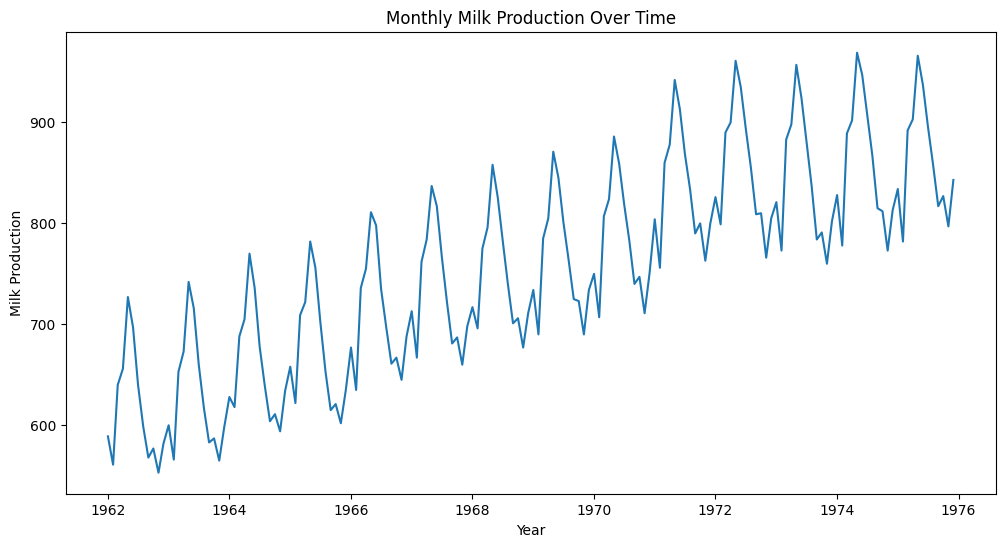

In [22]:
# Visualize Trend & Seasonality

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df['Production'])
plt.title("Monthly Milk Production Over Time")
plt.xlabel("Year")
plt.ylabel("Milk Production")
plt.show()


In [23]:
# Extract year and month 
df['Year'] = df.index.year 
df['Month'] = df.index.month

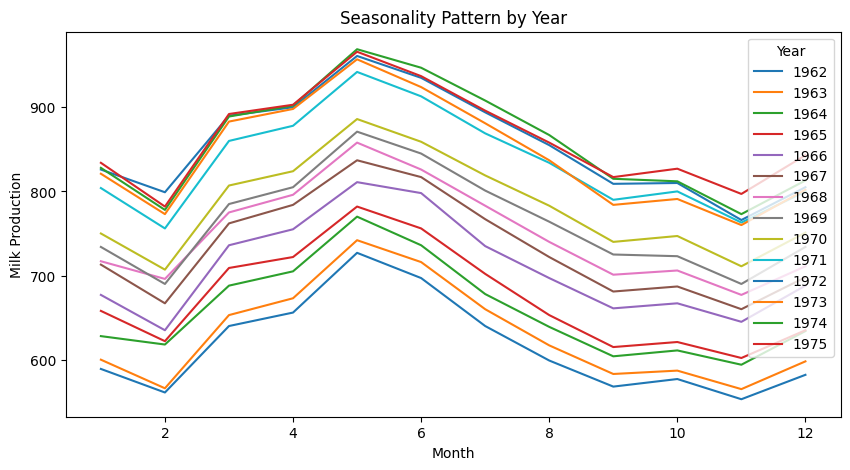

In [24]:
#  Seasonal Decomposition

# Seasonal pattern across years
plt.figure(figsize=(10,5))
sns.lineplot(data=df,x="Month", y="Production", hue="Year", palette="tab10")
plt.title("Seasonality Pattern by Year")
plt.xlabel("Month")
plt.ylabel("Milk Production")
plt.show()



In [25]:
#      Detect Outliers (Simple IQR method)

Q1 = df['Production'].quantile(0.25)
Q3 = df['Production'].quantile(0.75)
IQR = Q3 - Q1

outliers = df[(df['Production'] < Q1 - 1.5*IQR) | 
              (df['Production'] > Q3 + 1.5*IQR)]

print(outliers)


Empty DataFrame
Columns: [Production, Year, Month]
Index: []


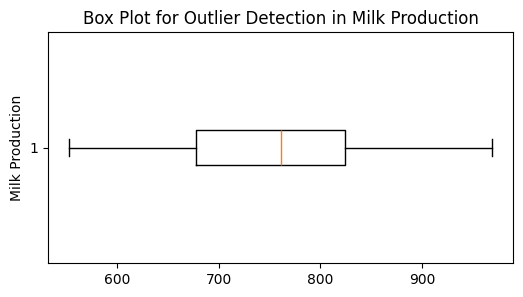

In [26]:
# Box plot to check for outliers
plt.figure(figsize=(6,3))
plt.boxplot(df['Production'], vert=False)
plt.title("Box Plot for Outlier Detection in Milk Production")
plt.ylabel("Milk Production")
plt.show()


In [28]:
#  Normalize / Scale for Neural Networks

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['Milk_Scaled'] = scaler.fit_transform(df[['Production']])

print(df.head())


            Production  Year  Month  Milk_Scaled
Date                                            
1962-01-01         589  1962      1     0.086538
1962-02-01         561  1962      2     0.019231
1962-03-01         640  1962      3     0.209135
1962-04-01         656  1962      4     0.247596
1962-05-01         727  1962      5     0.418269


In [30]:
Data = pd.DataFrame(
    df["Milk_Scaled"],
    index=df.index,
    columns=["Milk_Scaled"]
)

Data.head()

,Milk_Scaled
Date,
1962-01-01,0.086538
1962-02-01,0.019231
1962-03-01,0.209135
1962-04-01,0.247596
1962-05-01,0.418269


In [ ]:
#                                                    2.	Data Preparation for Deep Learning


In [31]:
#     Create Input–Output Sequences

import numpy as np

# This function converts time series into supervised learning format
def create_sequences(data, window_size):
    X = []
    y = []
    
    for i in range(len(data)-window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
    return np.array(X), np.array(y)

window_size = 12  # past 12 months → predict next month

# Convert data into sequences
values = Data.values

X, y = create_sequences(values, window_size)

print(X.shape, y.shape)


(156, 12, 1) (156, 1)


In [32]:
#    Split into Train / Val / Test

train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

print(X_train.shape, X_val.shape, X_test.shape)


(109, 12, 1) (23, 12, 1) (24, 12, 1)


In [34]:
#   Reshape for RNN / LSTM / GRU

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val   = X_val.reshape((X_val.shape[0],   X_val.shape[1],   1))
X_test  = X_test.reshape((X_test.shape[0],  X_test.shape[1],  1))

print(X_train.shape)


(109, 12, 1)


In [ ]:
#                                                                    3.	Model Building


In [33]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [35]:
import tensorflow as tf
print(tf.__version__)


2.18.0


In [ ]:
#                                                                 Basic RNN Model

In [43]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(64, input_shape=(X_train.shape[1], 1)))
rnn_model.add(Dense(1)) # Output layer

rnn_model.compile(
    optimizer='adam',
    loss='mse'
)
rnn_model.summary()


history_rnn = rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    verbose=1
)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289 (16.75 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.1063 - val_loss: 0.0177
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0225 - val_loss: 0.0665
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0137 - val_loss: 0.0061
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0117 - val_loss: 0.0175
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0060 - val_loss: 0.0165
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0036 - val_loss: 0.0068
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0041 - val_loss: 0.0096
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0031 - val_loss: 0.0065
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0029 - val_loss: 0.0062
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0024 - val_loss: 0.0057
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0021 - val_loss: 0.0051
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0019 - val_lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


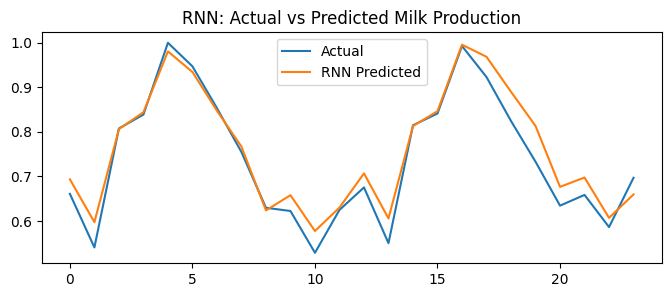

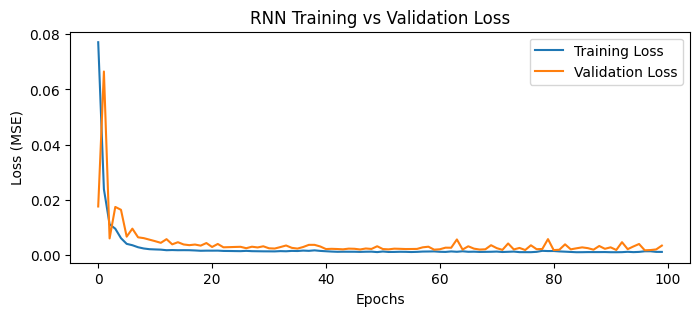

In [44]:

# Make predictions using RNN
rnn_pred = rnn_model.predict(X_test)

# Plot actual vs predicted values (RNN)
plt.figure(figsize=(8,3))
plt.plot(y_test, label="Actual")
plt.plot(rnn_pred, label="RNN Predicted")
plt.title("RNN: Actual vs Predicted Milk Production")
plt.legend()
plt.show()

# Training vs Validation Loss (RNN)
plt.figure(figsize=(8,3))
plt.plot(history_rnn.history['loss'], label='Training Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title("RNN Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()



In [ ]:
"""
Both training and validation losses gradually decreased, indicating that 
the model learned in a stable manner without overfitting. However, due to the
limited memory of standard RNNs, the model may struggle to 
capture long-term dependencies present in the data.

"""

In [ ]:
#                                                                                LSTM Model

In [38]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dense(1))

lstm_model.compile(
    optimizer='adam',
    loss='mse'
)
lstm_model.summary()

history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    verbose=1
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.1313 - val_loss: 0.1051
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0407 - val_loss: 0.0339
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0337 - val_loss: 0.0264
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0277 - val_loss: 0.0381
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0283 - val_loss: 0.0346
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0241 - val_loss: 0.0278
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0219 - val_loss: 0.0257
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0244 - val_loss: 0.0274
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0231 - val_loss: 0.0290
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0224 - val_loss: 0.0261
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0237 - val_loss: 0.0243
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0221 - val_lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


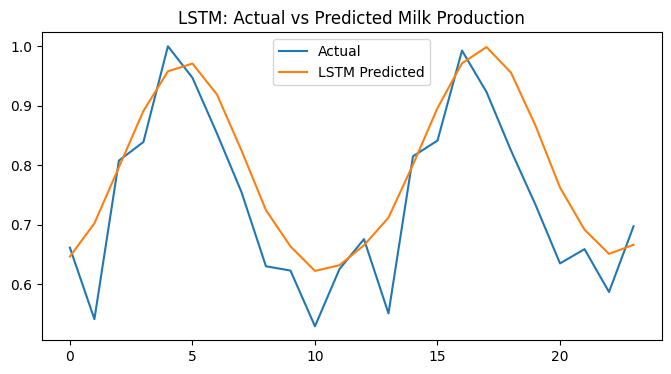

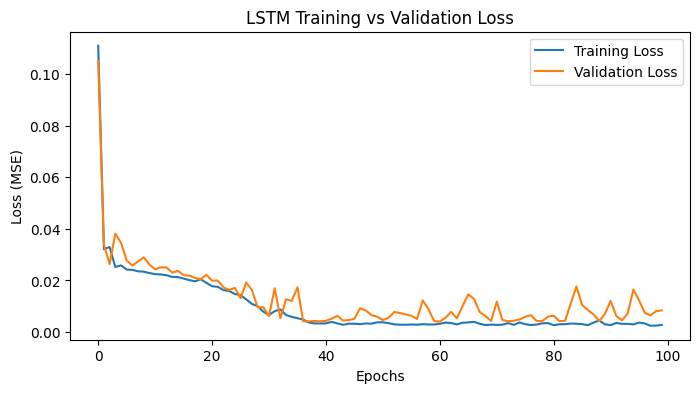

In [46]:

# Make predictions using LSTM
lstm_pred = lstm_model.predict(X_test)

# Actual vs predicted values (LSTM)
plt.figure(figsize=(8,4))
plt.plot(y_test, label="Actual")
plt.plot(lstm_pred, label="LSTM Predicted")
plt.title("LSTM: Actual vs Predicted Milk Production")
plt.legend()
plt.show()

# Training vs validation loss (LSTM)
plt.figure(figsize=(8,4))
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title("LSTM Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()




In [ ]:
"""

The training and validation losses decreased steadily, indicating good model performance. 
The predicted values closely match the actual values, showing that LSTM handles long-term patterns better.

"""

In [ ]:
#                                                                               GRU Model

In [55]:
gru_model = Sequential()
gru_model.add(GRU(64, input_shape=(X_train.shape[1], 1)))
gru_model.add(Dense(1))

gru_model.compile(
    optimizer='adam',
    loss='mse'
)
gru_model.summary()

history_gru = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    verbose=1
)
# Make predictions using GRU
gru_pred = gru_model.predict(X_test)


c:\Users\bunny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.2127 - val_loss: 0.2712
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0860 - val_loss: 0.0482
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0301 - val_loss: 0.0275
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0332 - val_loss: 0.0311
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0292 - val_loss: 0.0532
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0296 - val_loss: 0.0528
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0266 - val_loss: 0.0422
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0215 - val_loss: 0.0336
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0215 - val_loss: 0.0320
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0233 - val_loss: 0.0345
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0256 - val_loss: 0.0320
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0226 - val_lo

In [59]:
# Evaluation (MSE / RMSE)

import numpy as np

def evaluate(model, X, y, name):
    mse = model.evaluate(X, y, verbose=0)
    rmse = np.sqrt(mse)
    print(f"{name} – MSE: {mse:.6f}, RMSE: {rmse:.6f}")

evaluate(rnn_model,  X_test, y_test, "RNN")
evaluate(lstm_model, X_test, y_test, "LSTM")
evaluate(gru_model,  X_test, y_test, "GRU")


RNN – MSE: 0.001281, RMSE: 0.035788
LSTM – MSE: 0.006362, RMSE: 0.079760
GRU – MSE: 0.005476, RMSE: 0.074001


In [51]:
# Inverse scaling
y_test_inv = scaler.inverse_transform(y_test)
rnn_pred_inv = scaler.inverse_transform(rnn_pred)
lstm_pred_inv = scaler.inverse_transform(lstm_pred)


In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rnn_rmse = np.sqrt(mean_squared_error(y_test, rnn_pred))
rnn_mae = mean_absolute_error(y_test, rnn_pred)
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_pred))
lstm_mae = mean_absolute_error(y_test, lstm_pred)
gru_rmse = np.sqrt(mean_squared_error(y_test, gru_pred))
gru_mae = mean_absolute_error(y_test, gru_pred)

In [57]:
# comparison
results = pd.DataFrame({
    "Model": ["RNN", "LSTM" , "GRU"],
    "RMSE": [rnn_rmse, lstm_rmse, gru_rmse],
    "MAE": [rnn_mae, lstm_mae, gru_mae]
})

results


,Model,RMSE,MAE
0,RNN,0.035788,0.027842
1,LSTM,0.079760,0.063860
2,GRU,0.074001,0.064349
